## Phase of meta atom:

The notebook reproduces the phase of meta atom (Figure S1) in [Colburn et al,Science advances,2018](https://www.science.org/doi/full/10.1126/sciadv.aar2114)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)
from src import Scattering
from src import Plot
from src import Computation
from src import Geo

## Optical index

In [2]:
wavelength_range=np.array([700]) 
e_SiN=2.03**2 
e_SiN=np.array([e_SiN])
e_SiO2=1.45**2 
#reflectance and transmission
u_ref=1; u_trn=1;  e_ref=e_SiO2; e_trn=1;  e_air=1

## Input parameters

In [3]:
#Angle
AOI_d = 0
Azimuth_d=0
AOI_r=np.radians(AOI_d) 
Azimuth_r=np.radians(Azimuth_d) 

#geometry
Lx_cell=442; Ly_cell=442  #pitch in nm
reso=1      
Thickness_Sim=[633] # only one layer

# diffraction order in x-y direction
mx=5;my=5     

## Parameters in RCWA

In [4]:
NL=len(Thickness_Sim)
#Geometry
Geo.reso, Geo.Lx_cell, Geo.Ly_cell= reso, Lx_cell, Ly_cell
Geo.mx, Geo.my= mx, my
Geo.edge_sharpness=500

#Scattering
Scattering.AOI_r, Scattering.Azimuth_r =AOI_r, Azimuth_r
# important
Scattering.Meshgrid()
Scattering.Angles()

In [5]:
# Sweep
D_range=np.linspace(0,442,222)

In [6]:
#layer materials
Geometry=[]
for d_th in D_range:
    layer_lth={} 
    layer_lth['Shape']=Geo.Circle
    layer_lth['e_base']=1
    layer_lth['e_grt']=e_SiN
    layer_lth['Critical']=[d_th]
    layer_lth['Center']=[Lx_cell/2,Ly_cell/2]
    
    Geometry.append(layer_lth)  

## Visualization

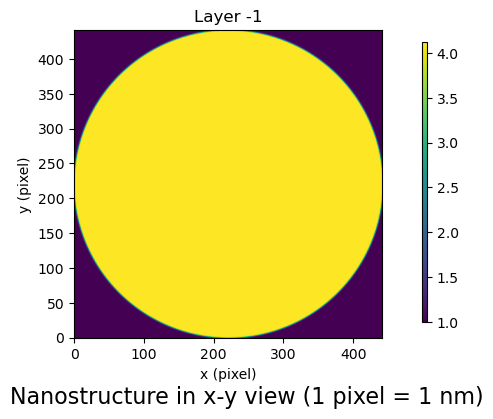

In [8]:
geo_e=np.array([Plot.Geo_viz(layer_lth) for layer_lth in Geometry])
Plot.Viz_xy(geo_e,pos_layer=[-1])

# Simulation

In [9]:
t0=time.time()
ERC_CONV=[Geo.CONV_layer(wavelength_range,layer_lth) for layer_lth in Geometry]
t_conv=time.time()-t0
print(t_conv)

4.197491407394409


In [10]:
t0=time.time()
Trn=[]
Ref=[]
T_x=[]
T_y=[]  
unit_mat=Scattering.unit_mat


Scattering.KxKy_Component(wavelength_range[0],e_ref,e_trn)  

for lth in  range(len(D_range)):        
      
    # S-layer        
    S11,S21=Scattering.S_Layer(Thickness_Sim[0],ERC_CONV[lth][0])      
    
    S_ref=Scattering.Ref_medium()      
    
    S_global_11,_,S_global_21,_=Computation.redheffer_global(unit_mat,S_ref,[S11,S21,S21,S11])  # only one layer
                  
    tx,ty= Scattering.Optical_Response(S_global_21,'pte')   
    #rx,ry= Scattering.Optical_Response(S_global_11,'pte') 
    T_x.append(tx)
    T_y.append(ty)    
    
    T=Scattering.Transmittance(tx,ty)    
    Trn.append(np.sum(T))      

Trn=np.array(Trn) 
T_x=np.array(T_x)
T_y=np.array(T_y)

print(time.time() -t0)    

20.18086051940918


In [11]:
order=Scattering.Nharm//2
phase=np.unwrap(-np.angle(T_y[:,order,0]))/2/np.pi

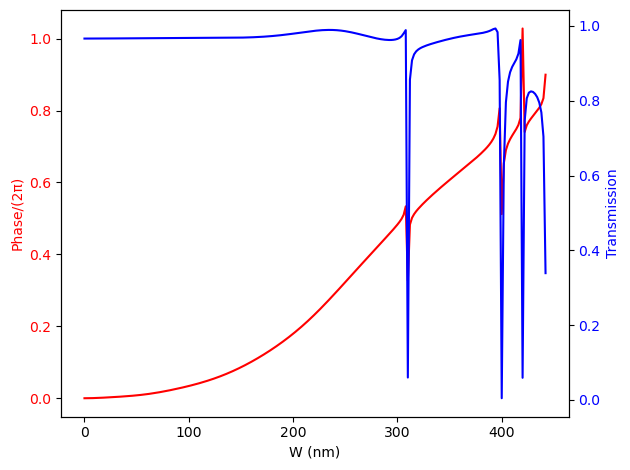

In [12]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('W (nm)')
ax1.set_ylabel('Phase/(2π)', c='r')
ax1.plot(D_range, phase-phase.min(),c='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx() 
ax2.set_ylabel('Transmission', c='blue')
ax2.plot(D_range, Trn,c='blue')

ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() 
plt.show()